In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy import spatial
import pickle
import numpy as np
import numba as nb

In [2]:
#os.chdir("prog2-2024-c2-barab")

In [3]:
df = pd.read_csv("solution-1/input.csv")
query_df = pd.read_csv("solution-1/query.csv")

<Axes: ylabel='Density'>

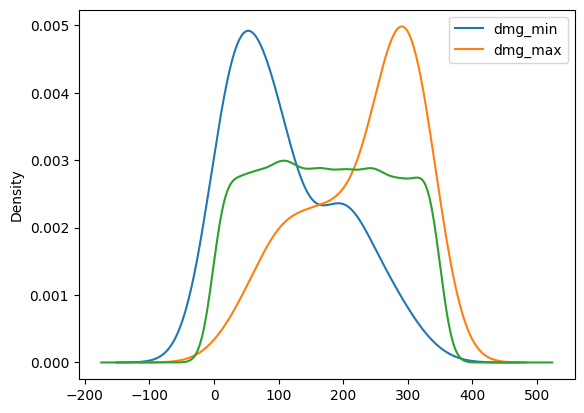

In [4]:
query_df[["dmg_min","dmg_max"]].plot.kde()
df["dmg"].plot.kde()

In [5]:
#Preproc
for dt in df["dmg_type"].unique():
    #print(dt)
    tree = spatial.cKDTree(df.loc[(df["dmg_type"] == dt),["x","y"]])
    with open("notebook_folder/tree_{}.pkl".format(dt),"wb") as file:
        pickle.dump(tree, file)
    """
    out_df = df.loc[(df["dmg_type"] == dt),["x","y","dmg"]]
    with open("notebook_folder/data_{}.pkl".format(dt),"wb") as file:
        pickle.dump(out_df, file)
    """
# Should this be sorted?
df[["dmg","dmg_type"]].to_pickle("notebook_folder/input.pkl")
with open("notebook_folder/dtypes.npy","wb") as file:
    np.save(file,df["dmg_type"].unique())
    



In [65]:
#Compute load
with open("notebook_folder/dtypes.npy","rb") as file:
    dtypes = np.load(file,allow_pickle=True)
for dt in dtypes:
    globals()["tree_" + dt] = pickle.load(open("notebook_folder/tree_{}.pkl".format(dt),"rb"))
    #globals()["df_" + dt] = pickle.load(open("notebook_folder/data_{}.pkl".format(dt),"rb"))
df_i = pd.read_pickle("notebook_folder/input.pkl")

  

In [66]:
# check function
@nb.njit
def check_numbers_between_numba(lst, min_val, max_val):
    for num in lst:
        if min_val <= num <= max_val:
            return True
    return False

In [87]:
# Compute calculate
#Probably can be parallelize
out_df = pd.DataFrame()
counter_df = pd.DataFrame()
counter_list = []
range_list = []
for dt in dtypes:
    dmg_list = []

    temp_dmgs = df_i.loc[(df_i["dmg_type"] == dt),["dmg"]].to_numpy()
    for idx, row in query_df.iterrows():
        #print("current id:",idx)
        if check_numbers_between_numba(temp_dmgs,row["dmg_min"],row["dmg_max"]):
            counter = 1
            while True:
                if counter == 1:
                    index = globals()["tree_" + dt].query(row[["x","y"]])[1]
                else:
                    index = globals()["tree_" + dt].query(row[["x","y"]],k=counter)[1][-1]
                    #rewrite this with function!
                if (temp_dmgs[index]>= row["dmg_min"]) & (temp_dmgs[index] <= row["dmg_max"]):
                    dmg_list.append(temp_dmgs[index])
                    break
                else:
                    counter += 1
            range_list.append(row["dmg_max"]-row["dmg_min"])
            counter_list.append(counter)
        else:
            dmg = 0
    out_df[dt] = dmg_list
counter_df = counter_df.assign(
    counter = counter_list,
    range_v = range_list
)


            
        

[152] 104.27745474661135 92.39818756305002
[309] 104.27745474661135 92.39818756305002
[99] 104.27745474661135 92.39818756305002
[35] 320.9061449313056 121.09226841931016
[110] 320.9061449313056 121.09226841931016
[224] 320.9061449313056 121.09226841931016
[253] 85.76235285679793 35.045495651565304
[14] 85.76235285679793 35.045495651565304
[347] 85.76235285679793 35.045495651565304
[269] 85.76235285679793 35.045495651565304
[46] 85.76235285679793 35.045495651565304
[86] 248.00905197187552 189.16573870569653
[135] 248.00905197187552 189.16573870569653
[273] 248.00905197187552 189.16573870569653
[300] 248.00905197187552 189.16573870569653
[143] 248.00905197187552 189.16573870569653
[148] 248.00905197187552 189.16573870569653
[324] 248.00905197187552 189.16573870569653
[15] 248.00905197187552 189.16573870569653
[77] 248.00905197187552 189.16573870569653
[198] 248.00905197187552 189.16573870569653
[185] 189.90024466201368 34.69463478013543
[224] 122.10093614261598 57.42156505860018
[325] 12

<Axes: xlabel='range_v', ylabel='counter'>

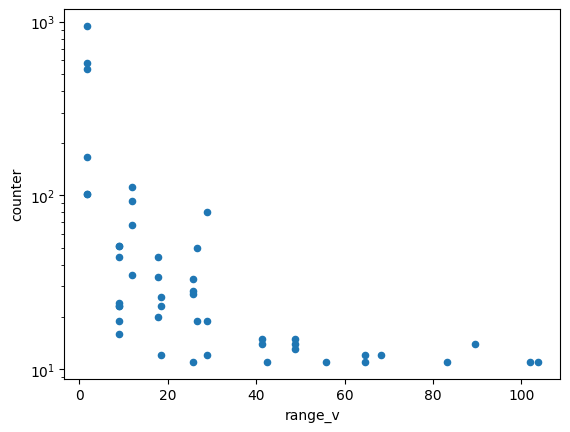

In [97]:
counter_df.loc[(counter_df["counter"]>10)].plot(x="range_v",y = "counter",kind="scatter",logy=True)

In [84]:
# Original
df = pd.read_csv("solution-1/input.csv")
query_df = pd.read_csv("solution-1/query.csv")

damage_types = df["dmg_type"].unique()
out = []
for idx, row in query_df.iterrows():
    out_row = {}
    for dt in damage_types:
        sub_df = df.loc[
            (df["dmg_type"] == dt)
            & (df["dmg"] >= row["dmg_min"])
            & (df["dmg"] <= row["dmg_max"]),
            ["x", "y", "dmg"],
        ]
        if sub_df.empty:
            out_row[dt] = 0
        else:
            diffs = ((sub_df[["x", "y"]] - row) ** 2).sum(axis=1)
            
            out_row[dt] = sub_df.iloc[diffs.argmin(), 2]
        #print(out_row)

    out.append(out_row)

original_out = pd.DataFrame(out)

In [56]:
%%timeit
# Compute calculate
#Probably can be parallelize
for dt in dtypes:
    temp_dmgs = df_i.loc[(df_i["dmg_type"] == dt),["dmg"]].to_numpy()
    for idx, row in query_df.iterrows():
        #print("current id:",idx)
        if check_numbers_between_numba(temp_dmgs,row["dmg_min"],row["dmg_max"]):b
            counter = 1
            while True:
                if counter == 1:
                    index = globals()["tree_" + dt].query(row[["x","y"]])[1]          
                else:
                    index = globals()["tree_" + dt].query(row[["x","y"]],k=counter)[1][-1]
                #print(df_i.loc[index,"dmg"],row["dmg_max"],row["dmg_min"])
                if (df_i.loc[index,"dmg"] >= row["dmg_min"]) & (df_i.loc[index,"dmg"] <= row["dmg_max"]):
                    dmg = df_i.loc[index,"dmg"]
                    break
                else:
                    counter += 1
        else:
            dmg = 0
        #print(dmg)

2.52 s ± 469 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [57]:
%%timeit
# Compute calculate
#Probably can be parallelize
for dt in dtypes:
    temp_dmgs = df_i.loc[(df_i["dmg_type"] == dt),["dmg"]].to_numpy()
    for idx, row in query_df.iterrows():
        #print("current id:",idx)
        if check_numbers_between_numba(temp_dmgs,row["dmg_min"],row["dmg_max"]):
            pass
        else:
            pass

36.2 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
id

511

In [47]:
os.getcwd()

'c:\\Projects\\Rajk\\prog_2\\second_hw\\prog2-2024-c2-barab'

In [61]:
i = 0
while True:
    if i < 10:
        print(i)
    else:
        break
    i +=1
    

0
1
2
3
4
5
6
7
8
9
